Here I am going to make some computations in order to understand the importance of each position in peptide epitope for immunogenicity prediction

In [1]:
%matplotlib inline

import os
from tqdm import tqdm, tqdm_notebook, tqdm_pandas
from tqdm import trange
import time
from scipy import stats
from scipy.stats import shapiro

import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import itertools
from modules.kidera import score_positions, score_sequence

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

Reading data

In [2]:
idf1 = pd.read_csv('data/immunogenic_peptides.csv')
idf2 = pd.read_csv('data/immunogenic_peptides.txt', sep='\t')
idf2 = idf2[idf2['Species']=='Homo']

idf1 = idf1.drop(['Epitope Start', 'Epitope End', ' Epitope Source Organism Name'], axis=1)
idf1.columns = ['Peptide', 'MHC', 'Length','Immunogenicity']

idf2["Species"] = idf2.Peptide.str.len()
idf2.columns = ['Peptide', 'MHC', 'Length','Immunogenicity']

idf1 = idf1.reset_index(drop=True)
idf2 = idf2.reset_index(drop=True)
idf = pd.concat([idf1, idf2], axis=0)
idf.Immunogenicity = idf.Immunogenicity.map({'immunogenic': 1, 'non-immunogenic': 0,
                                             'Positive': 1, 'Negative': 0})
idf.head()

,Peptide,MHC,Length,Immunogenicity
0,KLEDLERDL,HLA-A*02:01,9,1
1,DLMGYIPLV,HLA-A*02:01,9,1
2,QTVTSTPVQGR,HLA-A*68:01,11,1
3,TTVYPPSSTAK,HLA-A*03:01,11,1
4,LITGRLQSL,HLA-A2,9,1


In [3]:
def get_data(df, index):
    if index != -1:              
        df1 = df.Peptide.apply(
            lambda s: score_sequence("".join(list(np.delete(np.array([x for x in s]), index)))))
    else:
        df1 = df.Peptide.apply(lambda s: score_sequence(s))
        
    df = pd.concat([df, df1], axis=1)
    features = ["Length","helix.bend.pref", "side.chain.size",\
            "extended.str.pref", "hydrophobicity", "double.bend.pref", "partial.spec.vol",\
            "flat.ext.pref", "occurrence.alpha.reg", "pK.C", "surrounding.hydrop"]
    
    df = df.drop(["MHC"], axis=1)
    df.columns = ['Peptide', 'Length','Immunogenicity'] + features[1:]
    df = df[['Peptide', 'Immunogenicity'] + features]

    return df

In [4]:
ndf = get_data(idf, -1)

feats = ["helix.bend.pref", "side.chain.size",\
            "extended.str.pref", "hydrophobicity", "double.bend.pref", "partial.spec.vol",\
            "flat.ext.pref", "occurrence.alpha.reg", "pK.C", "surrounding.hydrop"]
ndf.head()

,Peptide,Immunogenicity,Length,helix.bend.pref,side.chain.size,extended.str.pref,hydrophobicity,double.bend.pref,partial.spec.vol,flat.ext.pref,occurrence.alpha.reg,pK.C,surrounding.hydrop
0,KLEDLERDL,1,9,-4.98,2.03,-5.96,4.23,-6.27,-6.21,1.99,-1.05,1.92,5.48
1,DLMGYIPLV,1,9,0.53,-1.72,0.77,-4.76,0.92,-4.45,0.07,0.72,-0.38,2.41
2,QTVTSTPVQGR,1,11,2.91,-5.14,8.00,4.67,1.97,-0.34,0.91,-6.23,-4.32,-1.91
3,TTVYPPSSTAK,1,11,5.26,-5.00,3.29,1.70,2.15,-5.02,-2.89,-9.42,-2.92,0.85
4,LITGRLQSL,1,9,-1.57,-2.39,3.65,-0.21,-3.00,-5.40,3.48,-2.81,-0.98,0.03


In [5]:
from sklearn.metrics import classification_report
skf = StratifiedKFold(n_splits=4)
train_index, test_index = next(iter(
    skf.split(idf[['Peptide', 'MHC', 'Length']], idf["Immunogenicity"])))

X_train = get_data(idf.iloc[train_index,:], -1)[feats]
y_train = idf["Immunogenicity"].iloc[train_index]
X_test = get_data(idf.iloc[test_index,:], -1)[feats]
y_test = idf["Immunogenicity"].iloc[test_index]

forest = RandomForestClassifier(100, max_features=None, min_samples_split=3, min_samples_leaf=3,\
                                random_state=42, n_jobs=-1, oob_score=True)
forest.fit(X_train, y_train)
feats_imp = pd.DataFrame(forest.feature_importances_,
                        index=feats, 
                        columns=['Importance']).sort_values(['Importance'], 
                                                     ascending=False)
print(classification_report(y_test, forest.predict(X_test), target_names=['Non-imm', 'Imm']))
print(roc_auc_score(y_test, forest.predict(X_test)))

             precision    recall  f1-score   support

    Non-imm       0.65      0.56      0.60      1214
        Imm       0.68      0.76      0.72      1537

avg / total       0.67      0.67      0.67      2751

0.6581406578424132


In [6]:
scores = []
for i in [8, 9, 10, 11]:
    score = []
    for j in [-1] + [l for l in range(i)]:
        test_df = idf.iloc[test_index,:]
        X_test = get_data(test_df[test_df['Length']==i], j)[feats]
        y_test = test_df[test_df['Length']==i]["Immunogenicity"]
        
        score.append(f1_score(y_test, forest.predict(X_test)))
        
    scores.append(score)

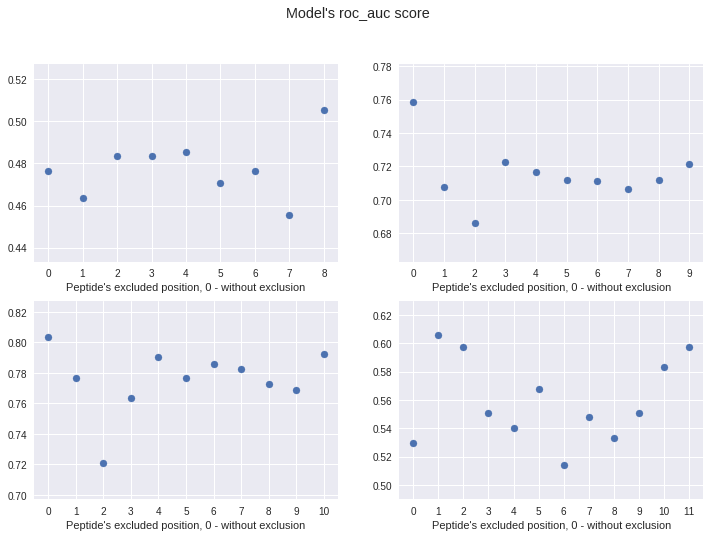

In [7]:
def plot_scores(data, ax, i):
    ax.scatter(range(len(data)), data)
    ax.set_xlabel("Peptide's excluded position, 0 - without exclusion")
    ax.set_xticks(range(i))

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(12, 8)
n=0
i=9
fig.suptitle("Model's roc_auc score")
for ax1, ax2 in axs:
    plot_scores(scores[n], ax1, i)
    n+=1
    i+=1
    plot_scores(scores[n], ax2, i)
    n+=1
    i+=1

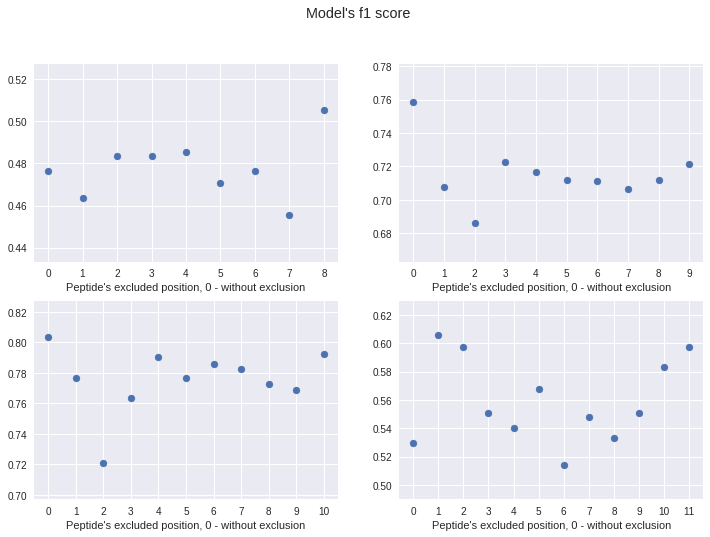

In [8]:
def plot_scores(data, ax, i):
    ax.scatter(range(len(data)), data)
    ax.set_xlabel("Peptide's excluded position, 0 - without exclusion")
    ax.set_xticks(range(i))

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(12, 8)
n=0
i=9
fig.suptitle("Model's f1 score")
for ax1, ax2 in axs:
    plot_scores(scores[n], ax1, i)
    n+=1
    i+=1
    plot_scores(scores[n], ax2, i)
    n+=1
    i+=1

In [9]:
datasets = []
for j in [-1] + [l for l in range(9)]:
    test_df = get_data(idf[idf['Length']==9], j)

    datasets.append(test_df)

In [10]:
from scipy.stats import normaltest

for feat in feats:
    wtf = normaltest(datasets[0][feat])
    print("{:<20} {:>20.04} {:>20.04}".format(feat, wtf.statistic, wtf.pvalue))

helix.bend.pref                     20.61             3.34e-05
side.chain.size                     44.49             2.18e-10
extended.str.pref                   3.128               0.2093
hydrophobicity                       26.9            1.441e-06
double.bend.pref                     3.01               0.2221
partial.spec.vol                    6.606              0.03678
flat.ext.pref                       51.89            5.397e-12
occurrence.alpha.reg                36.13            1.426e-08
pK.C                                23.92            6.405e-06
surrounding.hydrop                  139.0            6.441e-31


In [11]:
from sklearn.preprocessing import scale

norm_df = datasets[0].copy()

for feat in feats:
    norm_df[feat] = scale(norm_df[feat])

In [12]:
for feat in feats:
    wtf = normaltest(norm_df[feat])
    print("{:<20} {:>20.04} {:>20.04}".format(feat, wtf.statistic, wtf.pvalue))

helix.bend.pref                     20.61             3.34e-05
side.chain.size                     44.49             2.18e-10
extended.str.pref                   3.128               0.2093
hydrophobicity                       26.9            1.441e-06
double.bend.pref                     3.01               0.2221
partial.spec.vol                    6.606              0.03678
flat.ext.pref                       51.89            5.397e-12
occurrence.alpha.reg                36.13            1.426e-08
pK.C                                23.92            6.405e-06
surrounding.hydrop                  139.0            6.441e-31


In [13]:
stats.probplot(norm_df['double.bend.pref'], dist="norm", plot=pylab)
pylab.show()

NameError: name 'pylab' is not defined

In [ ]:
import pylab

stats.probplot(datasets[0]['double.bend.pref'], dist="norm", plot=pylab)
pylab.show()